### Денисов Владислав Львович, группа 3824М1ПМвм
### Лабораторная работа №3 «Перенос знаний с использованием PyTorch»

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import f1_score
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import time
import kagglehub
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [3]:
download_path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")
dataset_path = download_path + "/Garbage classification/Garbage classification"
print("Dataset path:", dataset_path)

tmp_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

tmp_dataset = datasets.ImageFolder(root=dataset_path, transform=tmp_transform)
tmp_loader = DataLoader(tmp_dataset, batch_size=64, shuffle=False, num_workers=2)

mean = torch.zeros(3)
std = torch.zeros(3)
nb_samples = 0

for images, _ in tmp_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, 3, -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print("Mean:", mean)
print("Std: ", std)

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

base_dataset = datasets.ImageFolder(root=dataset_path)
num_classes = len(base_dataset.classes)
print("Classes:", base_dataset.classes)

dataset_size = len(base_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

indices = list(range(dataset_size))
random.shuffle(indices)

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

# Создаем подмножества, чтобы избежать утечки данных между наборами
train_dataset = Subset(base_dataset, train_idx)
val_dataset = Subset(base_dataset, val_idx)
test_dataset = Subset(base_dataset, test_idx)

# Делаем независимые копии через deepcopy
train_dataset.dataset = deepcopy(base_dataset)
val_dataset.dataset = deepcopy(base_dataset)
test_dataset.dataset = deepcopy(base_dataset)

# Применяем соответствующие трансформации
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

print(f"Total: {dataset_size}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Using Colab cache for faster access to the 'garbage-classification' dataset.
Dataset path: /kaggle/input/garbage-classification/Garbage classification/Garbage classification
Mean: tensor([0.6732, 0.6399, 0.6049])
Std:  tensor([0.1804, 0.1796, 0.1902])
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Total: 2527
Train: 1768, Val: 379, Test: 380


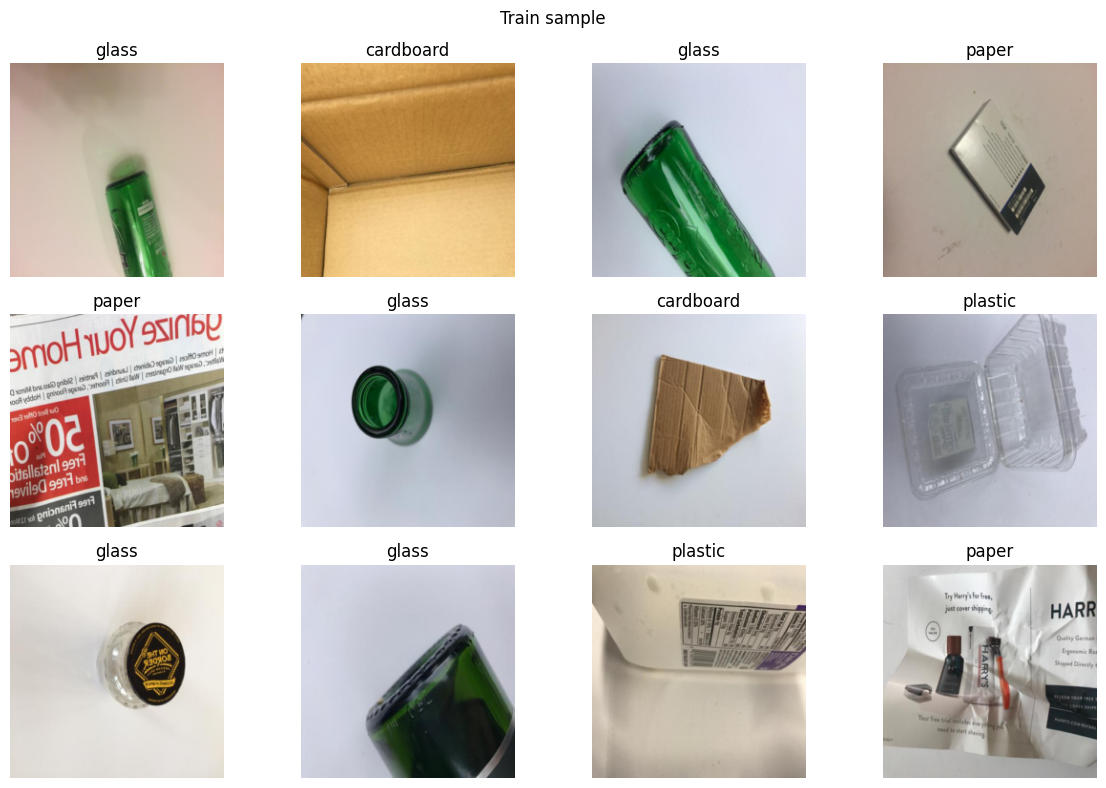

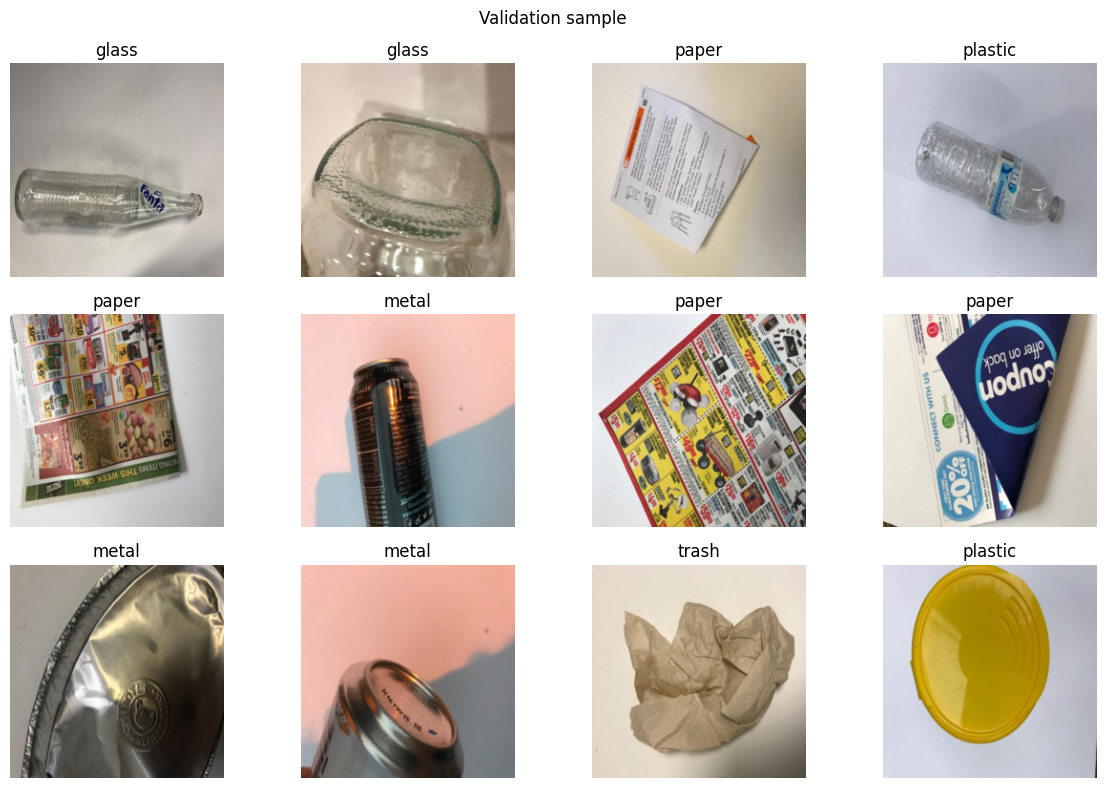

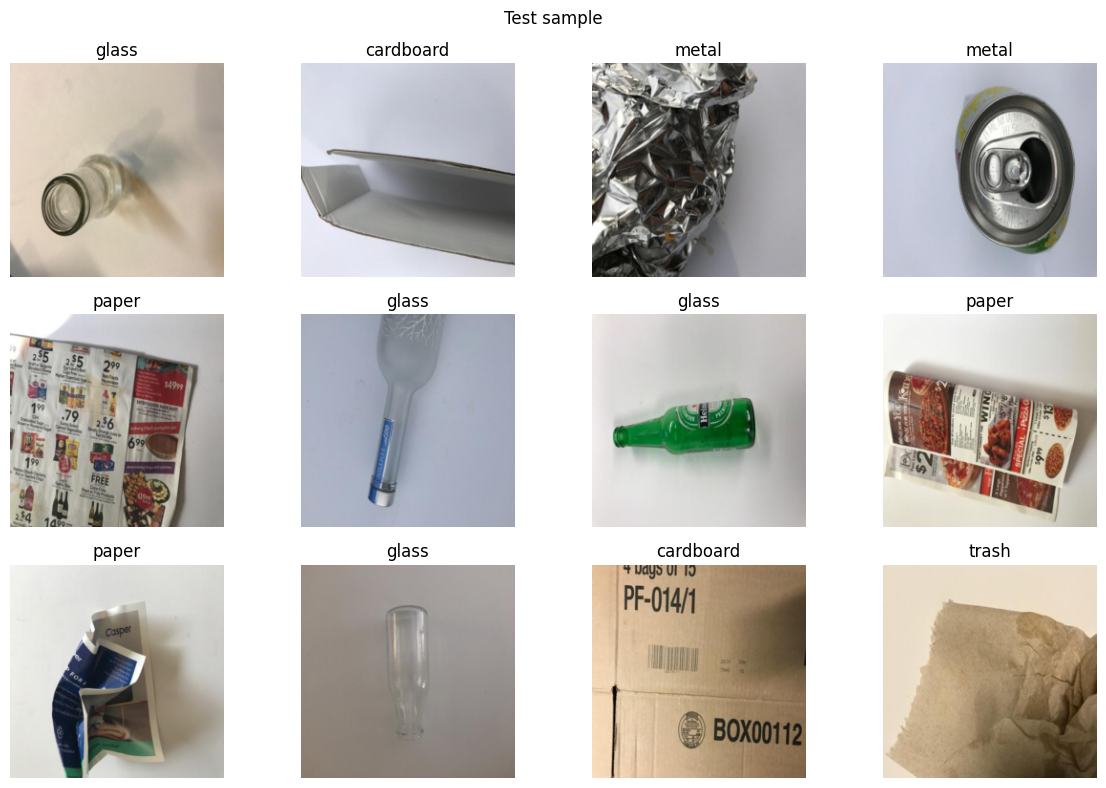

In [4]:
def show_examples(subset, mean, std, title="Примеры изображений"):
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    fig.suptitle(title)

    mean_np = mean.cpu().numpy().reshape(3, 1, 1)
    std_np = std.cpu().numpy().reshape(3, 1, 1)

    idxs = np.random.choice(len(subset), size=12, replace=len(subset) < 12)

    for ax, idx in zip(axes.flat, idxs):
        img, label = subset[idx]
        img = img.cpu().detach().numpy()

        img = img * std_np + mean_np
        img = np.clip(img, 0, 1)
        img = img.transpose(1, 2, 0)

        class_name = subset.dataset.classes[label]

        ax.imshow(img)
        ax.set_title(class_name)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_examples(train_dataset, mean, std, "Train sample")
show_examples(val_dataset, mean, std, "Validation sample")
show_examples(test_dataset, mean, std, "Test sample")

In [5]:
def get_model(name: str, num_classes: int, pretrained: bool = True):
    name = name.lower()

    if name == 'resnet50':
        model = models.resnet50(
            weights=models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        )
        if pretrained:
            for param in model.parameters():
                param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif name == 'densenet121':
        model = models.densenet121(
            weights=models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None
        )
        if pretrained:
            for param in model.features.parameters():
                param.requires_grad = False
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif name == 'vgg16':
        model = models.vgg16(
            weights=models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None
        )
        if pretrained:
            for param in model.features.parameters():
                param.requires_grad = False
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    elif name == 'googlenet':
        if pretrained:
            model = models.googlenet(
                weights=models.GoogLeNet_Weights.IMAGENET1K_V1,
                aux_logits=True
            )
            model.aux_logits = False
        else:
            model = models.googlenet(weights=None, aux_logits=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    else:
        raise ValueError(f"Неизвестная модель: {name}")

    return model.to(device)

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    history = {
        'train_loss': [],
        'train_acc': [],
        'train_f1': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }

    for epoch in range(num_epochs):
        start_time = time.time()

        # Обучение
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        all_preds, all_labels = [], []

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / total
        train_acc = 100 * correct / total
        train_f1 = f1_score(all_labels, all_preds, average='macro')

        # Валидация
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / total
        val_acc = 100 * correct / total
        val_f1 = f1_score(all_labels, all_preds, average='macro')

        epoch_time = time.time() - start_time

        print(f"Эпоха {epoch+1:02d}: "
              f"Train loss={train_loss:.4f}, acc={train_acc:.2f}%, f1={train_f1:.3f} | "
              f"Val loss={val_loss:.4f}, acc={val_acc:.2f}%, f1={val_f1:.3f} | "
              f"Время: {epoch_time:.2f} c")

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

    return model, history

In [7]:
def experiment_one_model(
    model_name: str,
    num_classes: int,
    train_loader,
    val_loader,
    num_epochs: int = 25,
    pretrained: bool = True,
    learning_rate: float = 1e-4,
    weight_decay: float = 1e-4
):
    tag = f"{model_name}_{'transfer' if pretrained else 'random'}"

    model = get_model(model_name, num_classes, pretrained=pretrained)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),  # обучаем только размороженные параметры
        lr=learning_rate,
        weight_decay=weight_decay
    )

    dataloaders = {'train': train_loader, 'val': val_loader}

    print(f"Обучение модели: {tag.upper()}")
    model, history = train_model(
        model=model,
        dataloaders=dataloaders,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=num_epochs
    )

    return model, history

In [8]:
def analyze_model(model, history, test_loader, tag, final_scores_dict=None):
    if final_scores_dict is None:
        final_scores_dict = {}

    # Оценка на тестовом наборе
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    test_f1 = f1_score(targets, preds, average='macro')
    final_scores_dict[tag] = test_f1
    print(f"{tag}: Test Macro F1 = {test_f1:.4f}")

    # График F1 на валидации
    plt.figure(figsize=(8, 5))
    plt.plot(history['val_f1'], label=f'{tag} (val F1)')
    plt.title(f'Изменение Macro F1 на валидации: {tag}')
    plt.xlabel('Эпоха')
    plt.ylabel('Macro F1')
    plt.legend()
    plt.show()

    return final_scores_dict

In [9]:
final_scores = {}

Обучение модели: VGG16_RANDOM
Эпоха 01: Train loss=1.7234, acc=23.13%, f1=0.119 | Val loss=1.6327, acc=27.70%, f1=0.137 | Время: 29.04 c
Эпоха 02: Train loss=1.5784, acc=35.92%, f1=0.300 | Val loss=1.5304, acc=35.88%, f1=0.268 | Время: 28.83 c
Эпоха 03: Train loss=1.4288, acc=42.48%, f1=0.355 | Val loss=1.3638, acc=45.91%, f1=0.376 | Время: 28.75 c
Эпоха 04: Train loss=1.3035, acc=48.64%, f1=0.417 | Val loss=1.2596, acc=50.40%, f1=0.462 | Время: 28.15 c
Эпоха 05: Train loss=1.2299, acc=52.04%, f1=0.467 | Val loss=1.1282, acc=54.62%, f1=0.512 | Время: 28.77 c
Эпоха 06: Train loss=1.1978, acc=53.45%, f1=0.494 | Val loss=1.2051, acc=53.56%, f1=0.438 | Время: 28.47 c
Эпоха 07: Train loss=1.1127, acc=58.09%, f1=0.531 | Val loss=1.1596, acc=55.67%, f1=0.485 | Время: 28.34 c
Эпоха 08: Train loss=0.9841, acc=62.78%, f1=0.588 | Val loss=0.9982, acc=61.74%, f1=0.579 | Время: 29.03 c
Эпоха 09: Train loss=0.8870, acc=67.25%, f1=0.642 | Val loss=0.9762, acc=63.85%, f1=0.589 | Время: 28.29 c
Эпоха 1

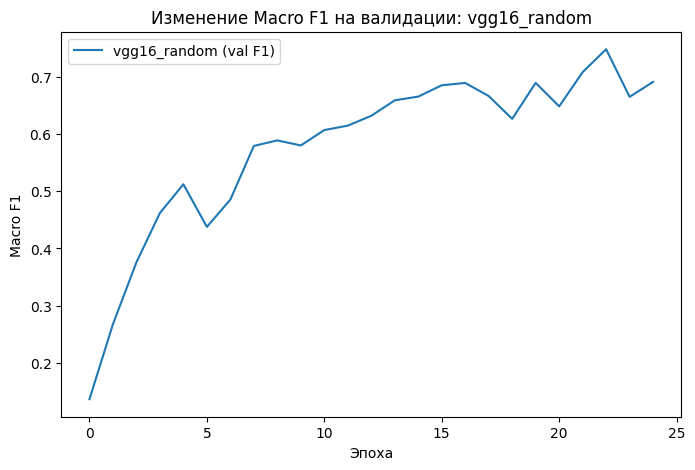

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 85.6MB/s]


Обучение модели: VGG16_TRANSFER
Эпоха 01: Train loss=0.9404, acc=64.88%, f1=0.593 | Val loss=0.5712, acc=79.68%, f1=0.767 | Время: 13.61 c
Эпоха 02: Train loss=0.4031, acc=85.86%, f1=0.837 | Val loss=0.4321, acc=83.64%, f1=0.813 | Время: 13.93 c
Эпоха 03: Train loss=0.2149, acc=92.82%, f1=0.920 | Val loss=0.4333, acc=83.38%, f1=0.812 | Время: 13.95 c
Эпоха 04: Train loss=0.1252, acc=96.15%, f1=0.954 | Val loss=0.3980, acc=86.81%, f1=0.848 | Время: 13.82 c
Эпоха 05: Train loss=0.0789, acc=97.96%, f1=0.978 | Val loss=0.4040, acc=86.81%, f1=0.847 | Время: 13.84 c
Эпоха 06: Train loss=0.0344, acc=99.10%, f1=0.990 | Val loss=0.4039, acc=87.60%, f1=0.866 | Время: 14.48 c
Эпоха 07: Train loss=0.0276, acc=99.26%, f1=0.992 | Val loss=0.4498, acc=86.54%, f1=0.854 | Время: 14.00 c
Эпоха 08: Train loss=0.0244, acc=99.38%, f1=0.994 | Val loss=0.4586, acc=87.60%, f1=0.863 | Время: 13.73 c
Эпоха 09: Train loss=0.0191, acc=99.60%, f1=0.996 | Val loss=0.4039, acc=88.39%, f1=0.877 | Время: 13.72 c
Эпоха

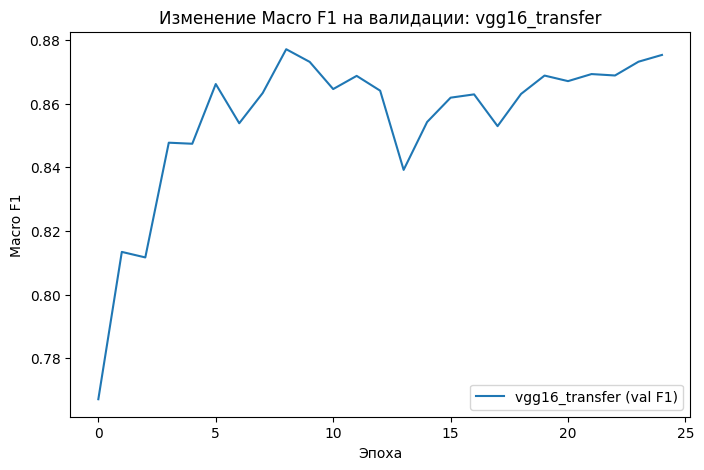

In [10]:
# VGG16, случайные веса
vgg_random_model, vgg_random_history = experiment_one_model(
    model_name='vgg16',
    num_classes=num_classes,
    train_loader=train_loader,
    val_loader=val_loader,
    pretrained=False
)

final_scores = analyze_model(
    model=vgg_random_model,
    history=vgg_random_history,
    test_loader=test_loader,
    tag='vgg16_random',
    final_scores_dict=final_scores
)

# VGG16, transfer learning
vgg_transfer_model, vgg_transfer_history = experiment_one_model(
    model_name='vgg16',
    num_classes=num_classes,
    train_loader=train_loader,
    val_loader=val_loader,
    pretrained=True
)

final_scores = analyze_model(
    model=vgg_transfer_model,
    history=vgg_transfer_history,
    test_loader=test_loader,
    tag='vgg16_transfer',
    final_scores_dict=final_scores
)

Обучение модели: GOOGLENET_RANDOM


/usr/local/lib/python3.12/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Эпоха 01: Train loss=1.2729, acc=50.51%, f1=0.430 | Val loss=1.9768, acc=16.89%, f1=0.048 | Время: 11.23 c
Эпоха 02: Train loss=0.9434, acc=65.50%, f1=0.598 | Val loss=1.8734, acc=28.23%, f1=0.177 | Время: 11.04 c
Эпоха 03: Train loss=0.7595, acc=73.42%, f1=0.696 | Val loss=1.3155, acc=56.99%, f1=0.534 | Время: 10.78 c
Эпоха 04: Train loss=0.7099, acc=73.47%, f1=0.711 | Val loss=0.8634, acc=69.66%, f1=0.654 | Время: 11.10 c
Эпоха 05: Train loss=0.6232, acc=77.55%, f1=0.747 | Val loss=1.1568, acc=61.48%, f1=0.536 | Время: 10.53 c
Эпоха 06: Train loss=0.5778, acc=80.32%, f1=0.784 | Val loss=0.9942, acc=69.92%, f1=0.658 | Время: 11.25 c
Эпоха 07: Train loss=0.4822, acc=83.31%, f1=0.816 | Val loss=0.8809, acc=72.82%, f1=0.706 | Время: 11.18 c
Эпоха 08: Train loss=0.4614, acc=84.11%, f1=0.823 | Val loss=1.2281, acc=65.70%, f1=0.610 | Время: 11.05 c
Эпоха 09: Train loss=0.4392, acc=84.62%, f1=0.824 | Val loss=0.8064, acc=71.77%, f1=0.687 | Время: 11.55 c
Эпоха 10: Train loss=0.3339, acc=88.1

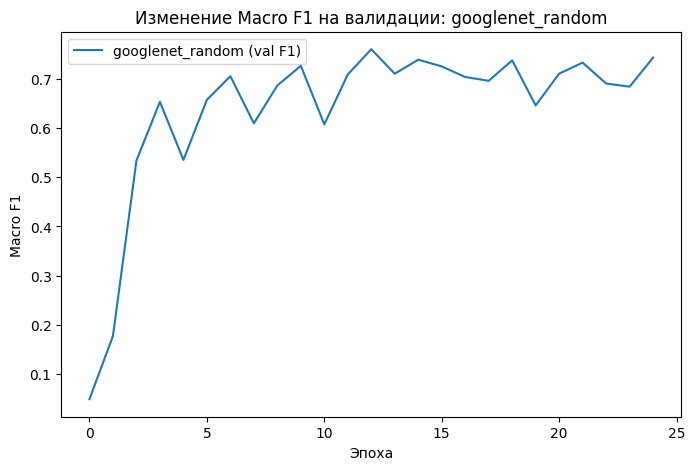

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 137MB/s]


Обучение модели: GOOGLENET_TRANSFER


/usr/local/lib/python3.12/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Эпоха 01: Train loss=1.3255, acc=56.56%, f1=0.484 | Val loss=0.8716, acc=76.78%, f1=0.651 | Время: 10.45 c
Эпоха 02: Train loss=0.6966, acc=80.03%, f1=0.709 | Val loss=0.5142, acc=84.96%, f1=0.795 | Время: 10.95 c
Эпоха 03: Train loss=0.4020, acc=89.82%, f1=0.848 | Val loss=0.3858, acc=88.39%, f1=0.849 | Время: 11.01 c
Эпоха 04: Train loss=0.2340, acc=95.14%, f1=0.938 | Val loss=0.3169, acc=89.97%, f1=0.874 | Время: 11.15 c
Эпоха 05: Train loss=0.1401, acc=97.51%, f1=0.969 | Val loss=0.2747, acc=92.08%, f1=0.903 | Время: 11.38 c
Эпоха 06: Train loss=0.0783, acc=99.10%, f1=0.990 | Val loss=0.2647, acc=92.61%, f1=0.911 | Время: 11.17 c
Эпоха 07: Train loss=0.0519, acc=99.49%, f1=0.994 | Val loss=0.2586, acc=91.56%, f1=0.902 | Время: 11.16 c
Эпоха 08: Train loss=0.0355, acc=99.55%, f1=0.995 | Val loss=0.2417, acc=91.56%, f1=0.902 | Время: 11.26 c
Эпоха 09: Train loss=0.0282, acc=99.83%, f1=0.998 | Val loss=0.2487, acc=91.56%, f1=0.899 | Время: 11.25 c
Эпоха 10: Train loss=0.0209, acc=99.7

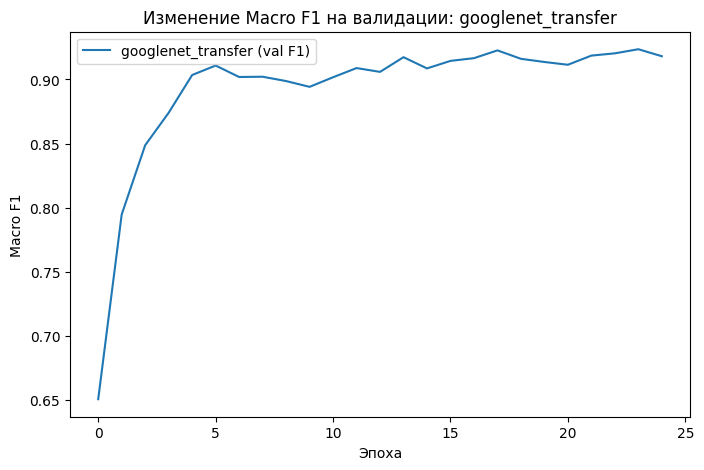

In [11]:
# GoogLeNet,  случайные веса
googlenet_random_model, googlenet_random_history = experiment_one_model(
    model_name='googlenet',
    num_classes=num_classes,
    train_loader=train_loader,
    val_loader=val_loader,
    pretrained=False
)

final_scores = analyze_model(
    model=googlenet_random_model,
    history=googlenet_random_history,
    test_loader=test_loader,
    tag='googlenet_random',
    final_scores_dict=final_scores
)

# GoogLeNet, transfer learning
googlenet_transfer_model, googlenet_transfer_history = experiment_one_model(
    model_name='googlenet',
    num_classes=num_classes,
    train_loader=train_loader,
    val_loader=val_loader,
    pretrained=True
)

final_scores = analyze_model(
    model=googlenet_transfer_model,
    history=googlenet_transfer_history,
    test_loader=test_loader,
    tag='googlenet_transfer',
    final_scores_dict=final_scores
)

Обучение модели: DENSENET121_RANDOM
Эпоха 01: Train loss=1.3564, acc=47.85%, f1=0.433 | Val loss=1.1503, acc=56.73%, f1=0.488 | Время: 20.65 c
Эпоха 02: Train loss=1.0329, acc=60.92%, f1=0.532 | Val loss=0.9591, acc=63.06%, f1=0.558 | Время: 21.34 c
Эпоха 03: Train loss=0.8787, acc=68.67%, f1=0.631 | Val loss=0.8884, acc=66.75%, f1=0.625 | Время: 20.64 c
Эпоха 04: Train loss=0.7906, acc=72.57%, f1=0.683 | Val loss=0.7819, acc=70.98%, f1=0.657 | Время: 20.75 c
Эпоха 05: Train loss=0.6666, acc=77.26%, f1=0.737 | Val loss=0.7616, acc=71.50%, f1=0.657 | Время: 21.34 c
Эпоха 06: Train loss=0.6007, acc=79.98%, f1=0.767 | Val loss=0.8031, acc=68.87%, f1=0.653 | Время: 20.62 c
Эпоха 07: Train loss=0.5305, acc=81.39%, f1=0.790 | Val loss=0.7297, acc=73.88%, f1=0.707 | Время: 20.62 c
Эпоха 08: Train loss=0.4671, acc=85.18%, f1=0.828 | Val loss=0.7226, acc=73.88%, f1=0.699 | Время: 21.19 c
Эпоха 09: Train loss=0.4559, acc=85.07%, f1=0.835 | Val loss=0.8089, acc=72.30%, f1=0.695 | Время: 20.51 c
Э

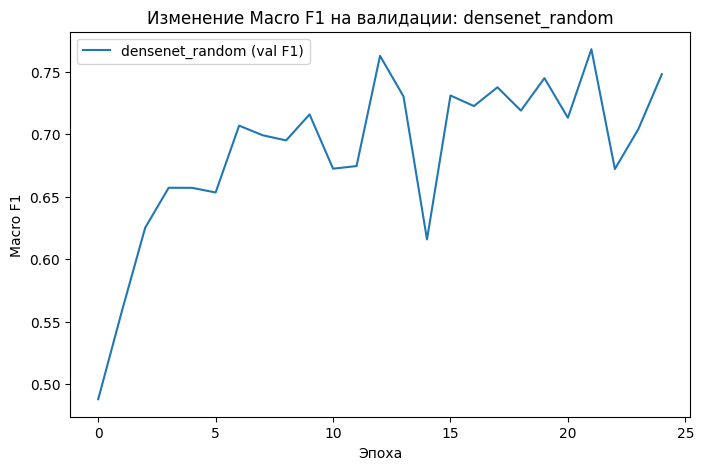

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 208MB/s]


Обучение модели: DENSENET121_TRANSFER
Эпоха 01: Train loss=1.8248, acc=17.19%, f1=0.156 | Val loss=1.6977, acc=28.50%, f1=0.206 | Время: 11.49 c
Эпоха 02: Train loss=1.6485, acc=30.37%, f1=0.230 | Val loss=1.5791, acc=36.41%, f1=0.278 | Время: 11.57 c
Эпоха 03: Train loss=1.5504, acc=40.10%, f1=0.321 | Val loss=1.4812, acc=45.12%, f1=0.351 | Время: 11.49 c
Эпоха 04: Train loss=1.4572, acc=47.96%, f1=0.387 | Val loss=1.3998, acc=50.92%, f1=0.411 | Время: 11.44 c
Эпоха 05: Train loss=1.3755, acc=54.52%, f1=0.454 | Val loss=1.3292, acc=57.78%, f1=0.474 | Время: 11.54 c
Эпоха 06: Train loss=1.3131, acc=59.50%, f1=0.497 | Val loss=1.2614, acc=63.32%, f1=0.531 | Время: 11.34 c
Эпоха 07: Train loss=1.2469, acc=63.40%, f1=0.536 | Val loss=1.2066, acc=64.64%, f1=0.541 | Время: 11.49 c
Эпоха 08: Train loss=1.1889, acc=66.35%, f1=0.566 | Val loss=1.1507, acc=67.02%, f1=0.563 | Время: 11.55 c
Эпоха 09: Train loss=1.1426, acc=67.65%, f1=0.588 | Val loss=1.1040, acc=68.60%, f1=0.576 | Время: 10.91 c

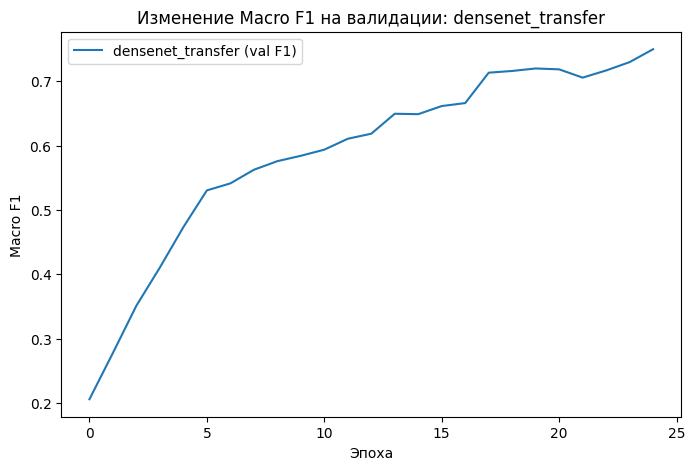

In [12]:
# Densenet121,  случайные веса
densenet_random_model, densenet_random_history = experiment_one_model(
    model_name='densenet121',
    num_classes=num_classes,
    train_loader=train_loader,
    val_loader=val_loader,
    pretrained=False
)

final_scores = analyze_model(
    model=densenet_random_model,
    history=densenet_random_history,
    test_loader=test_loader,
    tag='densenet_random',
    final_scores_dict=final_scores
)

# DenseNet121, transfer learning
densenet_transfer_model, densenet_transfer_history = experiment_one_model(
    model_name='densenet121',
    num_classes=num_classes,
    train_loader=train_loader,
    val_loader=val_loader,
    pretrained=True
)

final_scores = analyze_model(
    model=densenet_transfer_model,
    history=densenet_transfer_history,
    test_loader=test_loader,
    tag='densenet_transfer',
    final_scores_dict=final_scores
)

Обучение модели: RESNET50_RANDOM
Эпоха 01: Train loss=1.5415, acc=36.14%, f1=0.306 | Val loss=1.8383, acc=21.11%, f1=0.121 | Время: 20.66 c
Эпоха 02: Train loss=1.1939, acc=53.00%, f1=0.467 | Val loss=1.1279, acc=58.31%, f1=0.489 | Время: 20.80 c
Эпоха 03: Train loss=1.0486, acc=60.86%, f1=0.561 | Val loss=1.1969, acc=59.10%, f1=0.559 | Время: 20.35 c
Эпоха 04: Train loss=0.9473, acc=64.82%, f1=0.611 | Val loss=0.9922, acc=61.74%, f1=0.583 | Время: 20.52 c
Эпоха 05: Train loss=0.8587, acc=68.50%, f1=0.663 | Val loss=1.1619, acc=59.37%, f1=0.560 | Время: 20.95 c
Эпоха 06: Train loss=0.7722, acc=72.17%, f1=0.691 | Val loss=1.1144, acc=63.85%, f1=0.592 | Время: 20.38 c
Эпоха 07: Train loss=0.7241, acc=73.93%, f1=0.721 | Val loss=0.9887, acc=67.55%, f1=0.635 | Время: 20.56 c
Эпоха 08: Train loss=0.6219, acc=77.04%, f1=0.760 | Val loss=1.8128, acc=62.27%, f1=0.558 | Время: 21.12 c
Эпоха 09: Train loss=0.6443, acc=76.53%, f1=0.746 | Val loss=1.1334, acc=65.44%, f1=0.584 | Время: 20.52 c
Эпох

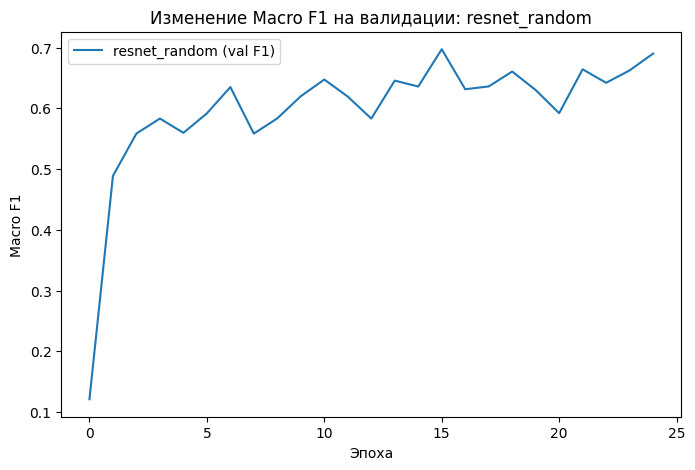

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


Обучение модели: RESNET50_TRANSFER
Эпоха 01: Train loss=1.6906, acc=27.38%, f1=0.192 | Val loss=1.5622, acc=44.06%, f1=0.312 | Время: 11.43 c
Эпоха 02: Train loss=1.5060, acc=51.92%, f1=0.410 | Val loss=1.4056, acc=59.89%, f1=0.495 | Время: 11.37 c
Эпоха 03: Train loss=1.3536, acc=62.61%, f1=0.524 | Val loss=1.2636, acc=65.70%, f1=0.541 | Время: 11.42 c
Эпоха 04: Train loss=1.2329, acc=68.78%, f1=0.584 | Val loss=1.1624, acc=74.41%, f1=0.629 | Время: 11.22 c
Эпоха 05: Train loss=1.1372, acc=72.34%, f1=0.620 | Val loss=1.0780, acc=74.67%, f1=0.631 | Время: 11.28 c
Эпоха 06: Train loss=1.0609, acc=75.28%, f1=0.645 | Val loss=1.0111, acc=75.73%, f1=0.640 | Время: 11.41 c
Эпоха 07: Train loss=0.9944, acc=75.90%, f1=0.656 | Val loss=0.9536, acc=75.99%, f1=0.644 | Время: 10.92 c
Эпоха 08: Train loss=0.9410, acc=76.30%, f1=0.665 | Val loss=0.8963, acc=76.78%, f1=0.652 | Время: 10.76 c
Эпоха 09: Train loss=0.8840, acc=79.41%, f1=0.695 | Val loss=0.8556, acc=78.36%, f1=0.666 | Время: 11.31 c
Эп

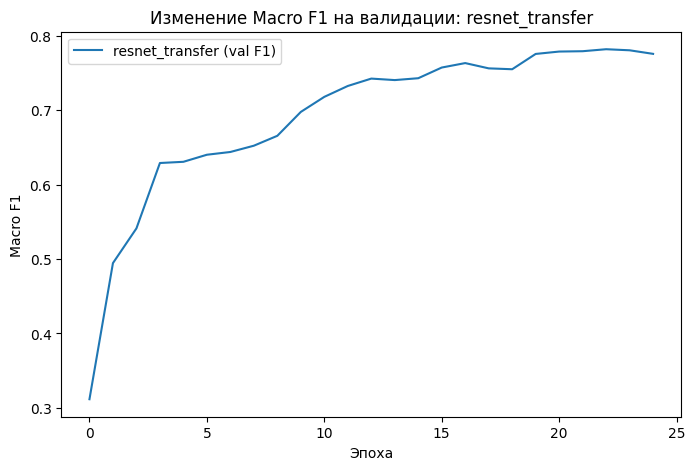

In [13]:
# Resnet50,  случайные веса
resnet_random_model, resnet_random_history = experiment_one_model(
    model_name='resnet50',
    num_classes=num_classes,
    train_loader=train_loader,
    val_loader=val_loader,
    pretrained=False
)

final_scores = analyze_model(
    model=resnet_random_model,
    history=resnet_random_history,
    test_loader=test_loader,
    tag='resnet_random',
    final_scores_dict=final_scores
)

# Resnet50, transfer learning
resnet_transfer_model, resnet_transfer_history = experiment_one_model(
    model_name='resnet50',
    num_classes=num_classes,
    train_loader=train_loader,
    val_loader=val_loader,
    pretrained=True
)

final_scores = analyze_model(
    model=resnet_transfer_model,
    history=resnet_transfer_history,
    test_loader=test_loader,
    tag='resnet_transfer',
    final_scores_dict=final_scores
)

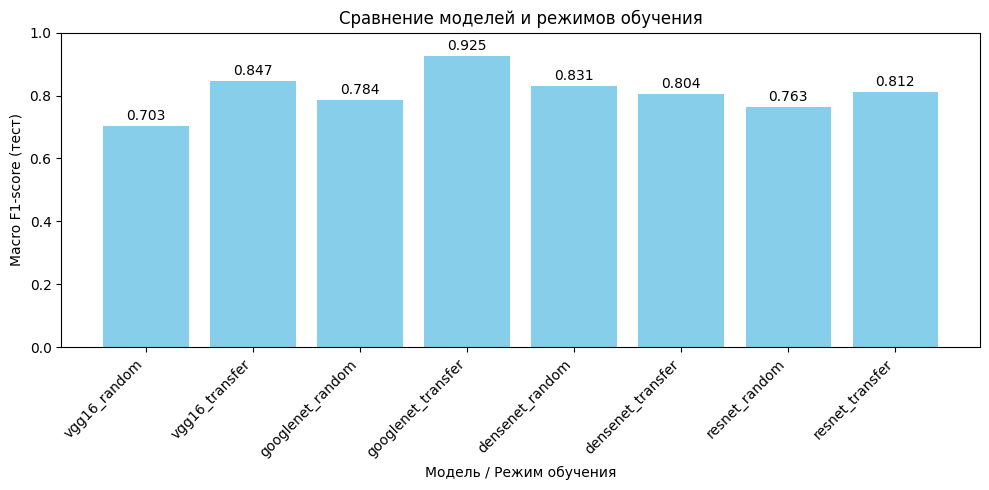

In [14]:
# Сравнительная диаграмма точности
plt.figure(figsize=(10, 5))
names = list(final_scores.keys())
scores = list(final_scores.values())
bars = plt.bar(names, scores, color='skyblue')
plt.ylabel('Macro F1-score (тест)')
plt.xlabel('Модель / Режим обучения')
plt.title('Сравнение моделей и режимов обучения')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)  # Макс F1 = 1
plt.tight_layout()

for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{score:.3f}', ha='center', va='bottom')

plt.show()